<a href="https://colab.research.google.com/github/rohitdutta2510/FusionNet-Custom-CNN-/blob/master/FusionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, Activation, MaxPooling2D, Add, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 

In [2]:
def identity_block(X, f, filters):

    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters, s = 1):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [3]:
def dense_layer(X, k=32):
    
    '''X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)'''
    
    X_shortcut = X
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid',  kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=k, kernel_size=(3, 3), strides=(1, 1), padding='same',  kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = concatenate([X_shortcut, X], axis=3)
    
    return X


def dense_block(X, dense_num = 6):
    
    '''X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)'''
    
    for l in range(dense_num):
        X = dense_layer(X)
    
    return X

In [4]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_1x1 = BatchNormalization(axis = 3)(conv_1x1)
    conv_1x1 = Activation('relu')(conv_1x1)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = BatchNormalization(axis = 3)(conv_3x3)
    conv_3x3 = Activation('relu')(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_3x3 = BatchNormalization(axis = 3)(conv_3x3)
    conv_3x3 = Activation('relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = BatchNormalization(axis = 3)(conv_5x5)
    conv_5x5 = Activation('relu')(conv_5x5)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    conv_5x5 = BatchNormalization(axis = 3)(conv_5x5)
    conv_5x5 = Activation('relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    pool_proj = BatchNormalization(axis = 3)(pool_proj)
    pool_proj = Activation('relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
    
    return output

In [5]:
def transition_layer(X, filters=128):
  
    '''X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)'''
    
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=filters, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(X)
    
    return X



In [6]:
def mixed_block(X, filters_residual_block, filters_1x1, filters_3x3_reduce, 
                filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, 
                n, s = 1):
  '''
  X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
  n -- no. of blocks
  '''

  res_block = convolutional_block(X, 
                                  f = 3, 
                                  filters = filters_residual_block)
  for i in range(n):
    res_block = identity_block(X = res_block, 
                               f = 3, 
                               filters = filters_residual_block)

  incep_block = inception_module(X,
                     filters_1x1 = filters_1x1,
                     filters_3x3_reduce = filters_3x3_reduce,
                     filters_3x3 = filters_3x3,
                     filters_5x5_reduce = filters_5x5_reduce,
                     filters_5x5 = filters_5x5,
                     filters_pool_proj = filters_pool_proj)
  
  des_block = dense_block(X,
                          dense_num = n*6)
  

  layer_concat = concatenate([res_block, incep_block, des_block], axis = -1)

  
  return layer_concat

In [7]:
def model(input_shape = (224, 224, 3), classes = 2):

    X_input = Input(input_shape)
    
    X = BatchNormalization(axis = 3)(X_input)
    X = Activation('relu')(X)
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)

    X_shortcut = BatchNormalization(axis = 3)(X)
    X_shortcut = Activation('relu')(X_shortcut)
    X_shortcut = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)

    X = mixed_block(X, 
                    filters_residual_block = [64,64,256],
                    filters_1x1=64,
                    filters_3x3_reduce=96,
                    filters_3x3=128,
                    filters_5x5_reduce=16,
                    filters_5x5=32,
                    filters_pool_proj=32,
                    n = 1, 
                    s = 1)
    
    X = concatenate([X, X_shortcut], axis = -1)
    X = transition_layer(X, 64)

    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    X_shortcut = Activation('relu')(X_shortcut)
    X_shortcut = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    X = mixed_block(X, 
                    filters_residual_block = [128,128,512],
                    filters_1x1=64,
                    filters_3x3_reduce=96,
                    filters_3x3=128,
                    filters_5x5_reduce=16,
                    filters_5x5=32,
                    filters_pool_proj=32,
                    n = 2, 
                    s = 1)
    

    X = concatenate([X, X_shortcut], axis = -1)
    X = transition_layer(X, 128)

    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    X_shortcut = Activation('relu')(X_shortcut)
    X_shortcut = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)

    X = mixed_block(X, 
                      filters_residual_block = [256,256,512],
                      filters_1x1=64,
                      filters_3x3_reduce=96,
                      filters_3x3=128,
                      filters_5x5_reduce=16,
                      filters_5x5=32,
                      filters_pool_proj=32, 
                      n = 3, 
                      s = 1)
    
    X = concatenate([X, X_shortcut], axis = -1)
    X = transition_layer(X, 192)
    
    X = Flatten()(X)
    X = BatchNormalization(axis=-1)(X)
    X = Dense(64, activation='relu')(X)

    X = BatchNormalization(axis=-1)(X)
    output = Dense(classes, activation='softmax')(X)

    model = tf.keras.Model(inputs=X_input, outputs=output)

    return model

In [8]:
fusion_net = model()

In [9]:
fusion_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        activation[0][0]                 
_______________________________________________________________________________________

In [10]:
tf.keras.utils.plot_model(fusion_net, expand_nested=True)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
x_train = np.load('/content/drive/My Drive/CXR_Datasets/Binary Classification/New_Btrain_images.npy')
y_train = np.load('/content/drive/My Drive/CXR_Datasets/Binary Classification/New_Btrain_labels.npy')
x_test = np.load('/content/drive/My Drive/CXR_Datasets/Binary Classification/New_Btest_images.npy')
y_test = np.load('/content/drive/My Drive/CXR_Datasets/Binary Classification/New_Btest_labels.npy')

In [13]:
x_train.shape

(1242, 224, 224, 3)

In [14]:
x_test.shape

(271, 224, 224, 3)

In [15]:
adam = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)

fusion_net.compile(optimizer = adagrad,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)

callbacks = [early_stop]

results = fusion_net.fit(x_train, y_train, epochs = 80,
                        validation_data = (x_test, y_test),
                        batch_size = 16,
                        callbacks = callbacks
                       )

Epoch 1/80
78/78 [==============================] - 18s 232ms/step - loss: 0.4370 - accuracy: 0.8873 - val_loss: 0.7273 - val_accuracy: 0.5018
Epoch 2/80
78/78 [==============================] - 14s 175ms/step - loss: 0.3721 - accuracy: 0.9525 - val_loss: 0.7777 - val_accuracy: 0.5018
Epoch 3/80
78/78 [==============================] - 14s 175ms/step - loss: 0.3628 - accuracy: 0.9573 - val_loss: 0.7416 - val_accuracy: 0.5055
Epoch 4/80
78/78 [==============================] - 14s 178ms/step - loss: 0.3525 - accuracy: 0.9686 - val_loss: 0.6440 - val_accuracy: 0.5978
Epoch 5/80
78/78 [==============================] - 14s 179ms/step - loss: 0.3463 - accuracy: 0.9702 - val_loss: 0.5742 - val_accuracy: 0.7122
Epoch 6/80
78/78 [==============================] - 14s 179ms/step - loss: 0.3382 - accuracy: 0.9823 - val_loss: 0.4394 - val_accuracy: 0.8708
Epoch 7/80
78/78 [==============================] - 14s 179ms/step - loss: 0.3385 - accuracy: 0.9807 - val_loss: 0.3802 - val_accuracy: 0.9373

In [17]:
fusion_net.evaluate(x_test, y_test)

9/9 [==============================] - 1s 75ms/step - loss: 0.3590 - accuracy: 0.9594


[0.35903486609458923, 0.9594095945358276]

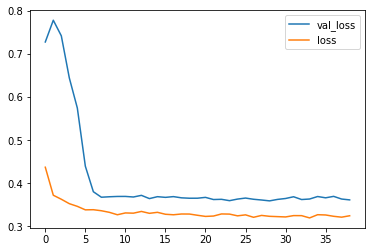

In [18]:
import pandas as pd
pd.DataFrame(results.history)[['val_loss', 'loss']].plot()

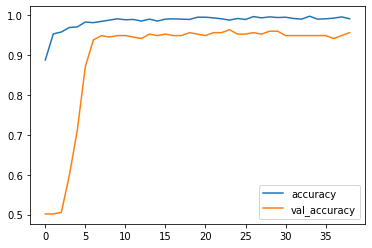

In [19]:
accuracy = pd.DataFrame(results.history)[['accuracy', 'val_accuracy']]
accuracy.plot()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(np.array(fusion_net.predict(x_test)), axis=1)
print(classification_report(y_pred=y_pred, y_true=y_test))
print(confusion_matrix(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       136
           1       0.98      0.94      0.96       135

    accuracy                           0.96       271
   macro avg       0.96      0.96      0.96       271
weighted avg       0.96      0.96      0.96       271

[[133   3]
 [  8 127]]
